<a href="https://colab.research.google.com/github/jimmiemunyi/deeplearning-experiments/blob/main/notebooks/PyTorch_Hooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq timm

     |████████████████████████████████| 376 kB 7.8 MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

import numpy as np
import matplotlib.pyplot as plt


In [3]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()

    self.conv = nn.Conv2d(3, 10, kernel_size=3)
    self.avgpool = nn.AdaptiveAvgPool2d(1)
    self.flatten = nn.Flatten()
    self.fc_1 = nn.Linear(10, 20)
    self.fc_2 = nn.Linear(20, 30)
    self.fc_3 = nn.Linear(30, 2)

  def forward(self, x):
    out = self.conv(x)
    out = self.avgpool(out)
    out = self.flatten(out)
    out = self.fc_1(out)
    out = self.fc_2(out)
    out = self.fc_3(out)
    out = F.relu(out)

    return out

In [4]:
x = torch.randn(1, 3, 224, 224)
net = Network()

net(x).shape

torch.Size([1, 2])

In [5]:
def activation_hook(inst, inp, out):
  print('This hook can access me')
  print(out.shape)

In [6]:
list(net.named_children())

[('conv', Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))),
 ('avgpool', AdaptiveAvgPool2d(output_size=1)),
 ('flatten', Flatten(start_dim=1, end_dim=-1)),
 ('fc_1', Linear(in_features=10, out_features=20, bias=True)),
 ('fc_2', Linear(in_features=20, out_features=30, bias=True)),
 ('fc_3', Linear(in_features=30, out_features=2, bias=True))]

In [7]:
x = torch.randn(1, 3, 224, 224)
net = Network()

for name, module in net.named_children():
  if isinstance(module, nn.Conv2d):
    print(f'adding hook to {name}')
    module.register_forward_hook(activation_hook)
net(x)

adding hook to conv
This hook can access me
torch.Size([1, 10, 222, 222])


tensor([[0., 0.]], grad_fn=<ReluBackward0>)

## Verbose Model Execution

In [8]:
class VerboseExecution(nn.Module):
  def __init__(self, model: nn.Module):
    super().__init__()
    self.model = model

    # Register a hook for each layer
    for name, layer in self.model.named_children():
      layer.__name__ = name
      layer.register_forward_hook(
          lambda layer, _, output: print(f'{layer.__name__}: {output.shape}')
      )
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.model(x)

In [9]:
model = timm.create_model('resnet18', pretrained=False)
verbose_model = VerboseExecution(model)

x = torch.randn(10, 3, 224, 224)
_ = verbose_model(x)

conv1: torch.Size([10, 64, 112, 112])
bn1: torch.Size([10, 64, 112, 112])
act1: torch.Size([10, 64, 112, 112])
maxpool: torch.Size([10, 64, 56, 56])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


layer1: torch.Size([10, 64, 56, 56])
layer2: torch.Size([10, 128, 28, 28])
layer3: torch.Size([10, 256, 14, 14])
layer4: torch.Size([10, 512, 7, 7])
global_pool: torch.Size([10, 512])
fc: torch.Size([10, 1000])


## Feature Extraction

In [10]:
from typing import Dict, Iterable, Callable

In [11]:
class FeatureExtractor(nn.Module):
  def __init__(self, model: nn.Module, layers: Iterable[str]):
    super().__init__()
    self.model = model
    self.layers = layers
    self._features = {layer: torch.empty(0) for layer in layers}

    for layer_id in layers:
      layer = dict([*self.model.named_modules()])[layer_id]
      layer.register_forward_hook(self.save_outputs_hook(layer_id))
    
  def save_outputs_hook(self, layer_id: str) -> Callable:
    def fn(_,__,output):
      self._features[layer_id] = output
    
    return fn

  def forward(self, x:torch.Tensor) -> Dict[str, torch.Tensor]:
    _ = self.model(x)
    return self._features

In [12]:
x = torch.randn(10, 3, 224, 224)

resnet_features = FeatureExtractor(model, layers=["layer4", "global_pool"])
features = resnet_features(x)

conv1: torch.Size([10, 64, 112, 112])
bn1: torch.Size([10, 64, 112, 112])
act1: torch.Size([10, 64, 112, 112])
maxpool: torch.Size([10, 64, 56, 56])
layer1: torch.Size([10, 64, 56, 56])
layer2: torch.Size([10, 128, 28, 28])
layer3: torch.Size([10, 256, 14, 14])
layer4: torch.Size([10, 512, 7, 7])
global_pool: torch.Size([10, 512])
fc: torch.Size([10, 1000])


In [13]:
print({name: output.shape for name, output in features.items()})

{'layer4': torch.Size([10, 512, 7, 7]), 'global_pool': torch.Size([10, 512])}


## CAM

In [14]:
class Hook():
  def hook_func(self, m, i, o):
    self.stored = o.detach().clone()
  
  def __repr__(self):
    return 'Conv Hook'

In [15]:
conv_hook = Hook()

In [16]:
model = timm.create_model('resnet18', pretrained=False)

for name, module in model.named_children():
  if isinstance(module, nn.Conv2d):
    print(f'adding hook to {name}')
    hook = module.register_forward_hook(conv_hook.hook_func)

input = torch.randn(10, 3, 224, 224)
output = model(input)

hook.remove()

adding hook to conv1


In [17]:
act = conv_hook.stored

In [18]:
act.shape

torch.Size([10, 64, 112, 112])

## Visualizing Activation in Resnet-34

In [19]:
class Hook():
  def __init__(self, m):
    # list to store all of our hooks
    self.hooks = []
    for name, module in m.named_modules():
      if isinstance(module, nn.Conv2d):
          print(f'adding hook to {name}')
          hook = module.register_forward_hook(self.hook_func)
          self.hooks.append(hook)
    
    self.hists = []
    self.stored, self.removed = None, False
  
  def hook_func(self, m, i, o):
    "Applies `hook_func` to `module`, `input`, `output`."
    output = o.detach().clone()
    self.hists.append(output.cpu().histc(40, 0, 10))
  
  def remove(self):
    "Remove the hook from the model."
    if not self.removed:
      for hook in self.hooks:
        hook.remove()
      self.removed=True

  def __enter__(self, *args):
    return self
  
  def __exit__(self, *args):
    self.remove()

In [20]:
model = timm.create_model('resnet18', pretrained=False)
with Hook(model) as hook:
  input = torch.randn(10, 3, 224, 224)
  output = model(input)
  acts = hook.hists

len(acts)

adding hook to conv1
adding hook to layer1.0.conv1
adding hook to layer1.0.conv2
adding hook to layer1.1.conv1
adding hook to layer1.1.conv2
adding hook to layer2.0.conv1
adding hook to layer2.0.conv2
adding hook to layer2.0.downsample.0
adding hook to layer2.1.conv1
adding hook to layer2.1.conv2
adding hook to layer3.0.conv1
adding hook to layer3.0.conv2
adding hook to layer3.0.downsample.0
adding hook to layer3.1.conv1
adding hook to layer3.1.conv2
adding hook to layer4.0.conv1
adding hook to layer4.0.conv2
adding hook to layer4.0.downsample.0
adding hook to layer4.1.conv1
adding hook to layer4.1.conv2


20

In [21]:
model = timm.create_model('resnet34', pretrained=False)
layers = list((model.children()))
model =  nn.Sequential(*layers)
print(len(model))
model[7][0].conv1

10


Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [22]:
def important_layers(model):
  model = nn.Sequential(*list(model.children()))
  imp = []

  # append important layers
  imp.append(model[0])
  imp.append(model[4][0].conv1)
  imp.append(model[5][0].conv1)
  imp.append(model[6][0].conv1)
  imp.append(model[7][0].conv1)

  return imp
  

In [23]:
model = timm.create_model('resnet18', pretrained=False)
important_layers(model)

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)]

In [24]:
names = [
    'conv1',
    'conv2_x',
    'conv3_x',
    'conv4_x',
    'conv5_x']

In [30]:
layer, name = (list(zip(important_layers(model), names))[0])
layer

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [31]:
name

'conv1'

In [44]:
class Hook():
  """
  This hook is meant to be used per layer
  that is, for every different layer you want to store its activations
  attach a different instance of this class

  __________________________________________
  Args:
  
  layer: nn.Module - The layer that you want to attach the hook
  name:str - The name you want to give that layer
  __________________________________________
  """
  def __init__(self, layer):
    self.hook = layer.register_forward_hook(self.hook_func)
    self.hists = []
    self.stored, self.removed = None, False
  
  def hook_func(self, m, i, o):
    "Applies `hook_func` to `module`, `input`, `output`."
    output = o.detach().clone()
    self.hists.append(output.cpu().histc(40, 0, 10))
  
  def remove(self):
    "Remove the hook from the model."
    if not self.removed:
      self.hook.remove()
      self.removed=True

  def __enter__(self, *args):
    return self
  
  def __exit__(self, *args):
    self.remove()

Testing For One Layer

Run Once

In [45]:
model = timm.create_model('resnet18', pretrained=False)
layer, name = list(zip(important_layers(model), names))[0]
with Hook(layer) as hook:
  input = torch.randn(10, 3, 224, 224)
  output = model(input)
  acts = hook.hists

len(acts), name

(1, 'conv1')

Run Multipe Times to simulate training loop

In [58]:
def get_hist(h): 
    return torch.stack(h.hists).t().float().log1p()

In [65]:
model = timm.create_model('resnet18', pretrained=False)
layer = important_layers(model)[0]

hook_1 = Hook(layer)
input = torch.randn(10, 3, 224, 224)

# Loop simulating training loop
for i in range(5):
  model(input)

# remember to remove the hook
hook_1.remove()

hook_1_hists = get_hist(hook_1)

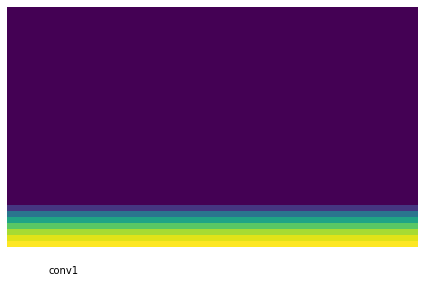

In [64]:
plt.plot(figsize=(15,10))
plt.imshow(get_hist(hook_1), origin='lower', aspect='auto')
plt.axis('off')
plt.text(0, -5, names[0], bbox={'facecolor':'red', 'alpha':0.0, 'pad':10})
plt.tight_layout()

Run for all layers now:

In [71]:
model = timm.create_model('resnet34', pretrained=True)

# store the hooks
hooks = []

# names of the layers
names = ['conv1',
         'conv2_x',
         'conv3_x',
         'conv4_x',
         'conv5_x']

# instantiate the hooks
for layer in important_layers(model):
  hooks.append(Hook(layer))

# Simulate training loop
for i in range(5):
  input = torch.randn(10, 3, 224, 224)
  model(input)

# remove the hooks at the end
for hook in hooks:
  hook.remove()

Plot the extracted activations now

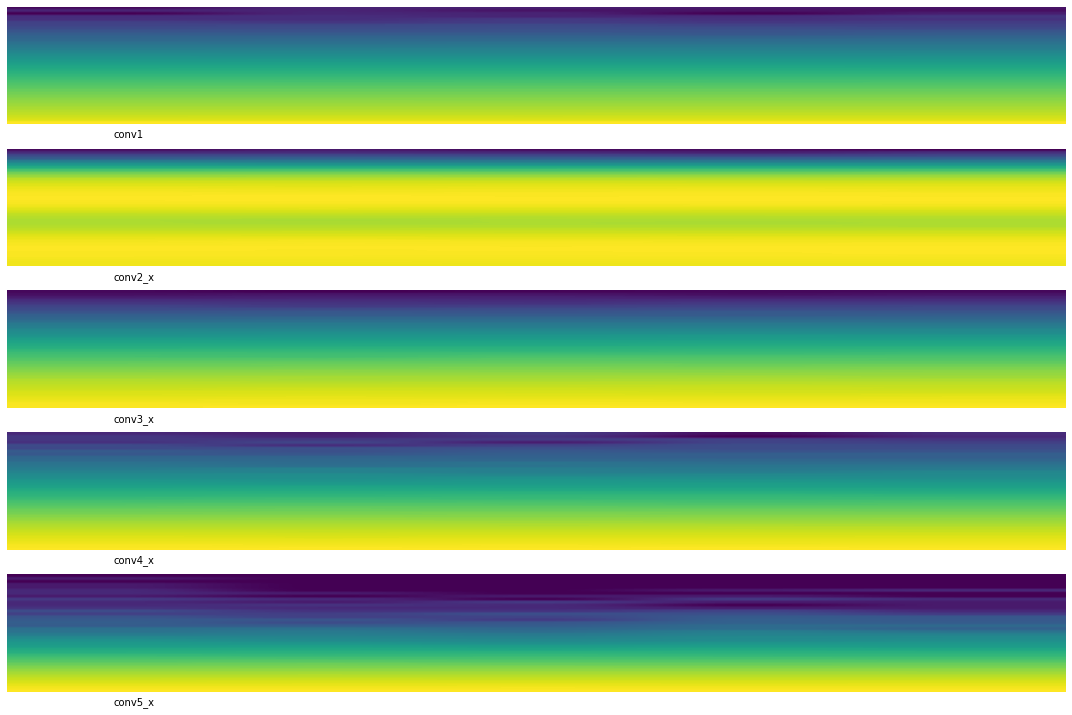

In [72]:
fig,axes = plt.subplots(5, figsize=(15,10))

for i, (ax,h) in enumerate(zip(axes.flatten(), hooks)):
    ax.imshow(get_hist(h), origin='lower', aspect='auto')
    ax.axis('off')
    ax.text(0, -5, names[i], bbox={'facecolor':'red', 'alpha':0.0, 'pad':10})
plt.tight_layout()

Yesssssss! Finally

Not these activations look similar all the way through but they will change during real training

Shoutout to this notebook: https://nbviewer.org/github/JoshVarty/VisualizingActivations/blob/master/VisualizingActivations.ipynb